In [128]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve,accuracy_score
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy import stats
from sklearn.metrics import  classification_report

# Dataset for Wa District

# Loading DataFrame

In [129]:
#Reading a CSV file named 'dataB.csv' and loading it into the DataFrame(importing data) 
df2 = pd.read_csv('dataw.csv')

df2['Date'] = pd.to_datetime(df2["Years"].astype(str) + '-' \
                             + df2['Months'].astype(str) + '-' + df2['Days'].astype(str))

df2.head()

Days  Months  Years  TAVG..Degrees.Fahrenheit. TAVG..Degrees. Celsius  \
0     1       1   1973                        NaN                #VALUE!   
1     2       1   1973                        NaN                #VALUE!   
2     3       1   1973                        NaN                #VALUE!   
3     4       1   1973                        NaN                #VALUE!   
4     5       1   1973                        NaN                #VALUE!   

   TMAX..Degrees.Fahrenheit. TMAX..Degrees. Celsius  \
0                        NaN                #VALUE!   
1                        NaN                #VALUE!   
2                        NaN                #VALUE!   
3                        NaN                #VALUE!   
4                        NaN                #VALUE!   

   TMIN..Degrees.Fahrenheit. TMIN..Degrees. Celsius  PRCP..Inches. PRCP .mm  \
0                        NaN                #VALUE!            NaN  #VALUE!   
1                        NaN                #VALUE!            NaN  #VALUE!   
2                        NaN                #VALUE!            NaN  #VALUE!   
3                        NaN                #VALUE!            NaN  #VALUE!   
4                        NaN                #VALUE!            NaN  #VALUE!   

   SNOW..Inches.  SNWD..Inches. Unnamed: 13       Date  
0            NaN            NaN         NaN 1973-01-01  
1            NaN            NaN         NaN 1973-01-02  
2            NaN            NaN         NaN 1973-01-03  
3            NaN            NaN         NaN 1973-01-04  
4            NaN            NaN         NaN 1973-01-05

 Writing the Days,Months,Years in the "Date" format 

# Data Management

In [130]:
#checking the missing data pattern in the dataset.
sns.heatmap(df2.isnull(), cbar=False, cmap='PuBu')

total = df2.isnull().sum().sort_values(ascending=False)
percent = (df2.isnull().sum()/df2.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


# Set values to 0 for rows with months 11, 12, 01, 02, and 03
df2.loc[df2['Months'].isin([11, 12, 1, 2]), 'PRCP .mm'] = 0


#Filling missing values by using the mode of each column to fill missing values in specific columns.
df2['TMAX..Degrees.Fahrenheit.'] = df2['TMAX..Degrees.Fahrenheit.'].fillna(df2['TMAX..Degrees.Fahrenheit.'].mode()[0])
df2['TMIN..Degrees.Fahrenheit.'] = df2['TMIN..Degrees.Fahrenheit.'].fillna(df2['TMIN..Degrees.Fahrenheit.'].mode()[0])
df2['TAVG..Degrees.Fahrenheit.'] = df2['TAVG..Degrees.Fahrenheit.'].fillna(df2['TAVG..Degrees.Fahrenheit.'].mode()[0])
df2['PRCP..Inches.'] = df2['PRCP..Inches.'].fillna(df2['PRCP..Inches.'].mode()[0])


columns_to_delete = ['TMAX..Degrees. Celsius','TMIN..Degrees. Celsius', 'TAVG..Degrees. Celsius', 'PRCP .mm', 'SNOW..Inches.', 'SNWD..Inches.','Unnamed: 13']

# Delete the columns
df2.drop(columns=columns_to_delete, inplace=True)

"""
column_name = 'Days'
missing_count = df2['Days'].isnull().sum()
print("Missing data count in '{}' column: {}".format(column_name, missing_count))


column_name = 'Months'
missing_count = df2['Months'].isnull().sum()
print("Missing data count in '{}' column: {}".format(column_name, missing_count))


column_name = 'Years'
missing_count = df2['Years'].isnull().sum()
print("Missing data count in '{}' column: {}".format(column_name, missing_count))


column_name = 'TAVG..Degrees.Fahrenheit.'
missing_count = df2['TAVG..Degrees.Fahrenheit.'].isnull().sum()
print("Missing data count in '{}' column: {}".format(column_name, missing_count))


column_name = 'TMAX..Degrees.Fahrenheit.'
missing_count = df2['TMAX..Degrees.Fahrenheit.'].isnull().sum()
print("Missing data count in '{}' column: {}".format(column_name, missing_count))


column_name = 'TMIN..Degrees.Fahrenheit.'
missing_count = df2['TMIN..Degrees.Fahrenheit.'].isnull().sum()
print("Missing data count in '{}' column: {}".format(column_name, missing_count))


column_name = 'PRCP..Inches.'
missing_count = df2['PRCP..Inches.'].isnull().sum()
print("Missing data count in '{}' column: {}".format(column_name, missing_count))
"""

df2["TAVG..Degrees.Fahrenheit._DC"] = (df2["TAVG..Degrees.Fahrenheit."] - 32) * 5/9
df2["TMAX..Degrees.Fahrenheit._DC"] = (df2["TMAX..Degrees.Fahrenheit."] - 32) * 5/9
df2["TMIN..Degrees.Fahrenheit._DC"] = (df2["TMIN..Degrees.Fahrenheit."] - 32) * 5/9
df2["PRCP .mm"]=(df2["PRCP..Inches."])*24.5



#Renaming the columns
df2.rename(columns={'TAVG..Degrees.Fahrenheit._DC': 'TAVG(Degrees Celsius)'}, inplace=True)
df2.rename(columns={'TMAX..Degrees.Fahrenheit._DC': 'TMAX(Degrees Celsius)'}, inplace=True)
df2.rename(columns={'TMIN..Degrees.Fahrenheit._DC': 'TMIN(Degrees Celsius)'}, inplace=True)


# Round the values in the DataFrame to two decimal places
df2 = df2.round(2)



# Monthly rainfall plots and annual rainfall plots

In [131]:
# Convert the 'Date' column to a datetime object
df2['Date'] = pd.to_datetime(df2['Date'])

# Set the 'Date' column as the DataFrame index
df2.set_index('Date', inplace=True)

# Calculate the average monthly rainfall for all the years
average_monthly_rainfall = df2['PRCP .mm'].groupby(df2.index.month).mean()

# Plot the average monthly rainfall
plt.figure(figsize=(10, 6))
plt.plot(average_monthly_rainfall.index, average_monthly_rainfall.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.title('Average Monthly Rainfall for All Years')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()




# Resample the data to annual rainfall
annual_rainfall = df2['PRCP .mm'].resample('Y').sum()

# Plot annual rainfall
plt.figure(figsize=(10, 6))
plt.plot(annual_rainfall.index, annual_rainfall.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.title('Annual Rainfall')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Missing value totals

In [132]:
columns_to_delete = ['TAVG..Degrees.Fahrenheit.','Days'\
                     ,'Months','Years','TMAX..Degrees.Fahrenheit.', 'TMIN..Degrees.Fahrenheit.']

# Delete the columns
df2.drop(columns =columns_to_delete, inplace=True)
df2 = df2.drop('PRCP..Inches.', axis=1)

missing.head()

Total   Percent
SNOW..Inches.              18262  1.000000
SNWD..Inches.              18261  0.999945
PRCP..Inches.              16517  0.904446
TMAX..Degrees.Fahrenheit.  14400  0.788523
TMIN..Degrees.Fahrenheit.  14392  0.788085

# Feature selection

In [133]:
df2.head()

TAVG(Degrees Celsius)  TMAX(Degrees Celsius)  \
Date                                                       
1973-01-01                  29.44                  32.22   
1973-01-02                  29.44                  32.22   
1973-01-03                  29.44                  32.22   
1973-01-04                  29.44                  32.22   
1973-01-05                  29.44                  32.22   

            TMIN(Degrees Celsius)  PRCP .mm  
Date                                         
1973-01-01                  22.22       0.0  
1973-01-02                  22.22       0.0  
1973-01-03                  22.22       0.0  
1973-01-04                  22.22       0.0  
1973-01-05                  22.22       0.0

# Converting the precipitation column into binary number

In [134]:
def convert_column_to_binary(data, column_name, threshold):
    data[column_name] = data[column_name].apply(lambda x: 1 if x >= threshold else 0)
    return data

data = df2

threshold = 0.2
column_name = 'PRCP .mm'

data = convert_column_to_binary(data, column_name, threshold)

# Separate features (X) and target variable (y)
X = df2.drop('PRCP .mm', axis=1)  # Adjust 'target_variable' with the name of your target variable column
y = df2['PRCP .mm']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X_train and y_train into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
majority_class = train_data[train_data['PRCP .mm'] == 0]
minority_class = train_data[train_data['PRCP .mm'] == 1]

# Upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match the majority class samples
                              random_state=42)

# Downsample the majority class
majority_downsampled = resample(majority_class,
                                replace=False,  # No replacement
                                n_samples=len(minority_class),  # Match the minority class samples
                                random_state=42)

# Combine the upsampled minority class with the downsampled majority class
balanced_data = pd.concat([majority_downsampled, minority_upsampled])

In [135]:
df2 = balanced_data

In [136]:
# Split the data into input features (X) and target variable (y)
X = data.drop('PRCP .mm', axis=1)  # Assuming 'rainfall_occurrence' is the target variable
y = data['PRCP .mm']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# The shape of the dataset after class imbalance

In [137]:
df2

TAVG(Degrees Celsius)  TMAX(Degrees Celsius)  \
Date                                                       
2000-01-09                  29.44                  32.22   
1989-05-04                  29.44                  32.22   
1987-09-02                  29.44                  32.22   
2008-10-26                  29.44                  32.22   
2016-08-15                  25.56                  26.67   
...                           ...                    ...   
2018-10-05                  27.78                  32.22   
1990-05-21                  23.89                  31.67   
2013-10-11                  25.56                  32.22   
2017-07-15                  27.78                  31.11   
1990-05-20                  27.22                  34.44   

            TMIN(Degrees Celsius)  PRCP .mm  
Date                                         
2000-01-09                  22.22         0  
1989-05-04                  22.22         0  
1987-09-02                  22.22         0  
2008-10-26                  22.22         0  
2016-08-15                  22.78         0  
...                           ...       ...  
2018-10-05                  23.89         1  
1990-05-21                  21.67         1  
2013-10-11                  20.00         1  
2017-07-15                  23.33         1  
1990-05-20                  21.11         1  

[14609 rows x 4 columns]

# ANNs Experimentation

In [138]:
import torch
import torch.nn as nn

class RainfallModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RainfallModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Define the model architecture and hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size = 64

model = RainfallModel(input_size, hidden_size)

type(1)

int

In [139]:
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch [5/1000], Loss: 0.4876
Epoch [10/1000], Loss: 0.3413
Epoch [15/1000], Loss: 0.2510
Epoch [20/1000], Loss: 0.1940
Epoch [25/1000], Loss: 0.1578
Epoch [30/1000], Loss: 0.1414
Epoch [35/1000], Loss: 0.1311
Epoch [40/1000], Loss: 0.1263
Epoch [45/1000], Loss: 0.1229
Epoch [50/1000], Loss: 0.1209
Epoch [55/1000], Loss: 0.1193
Epoch [60/1000], Loss: 0.1185
Epoch [65/1000], Loss: 0.1177
Epoch [70/1000], Loss: 0.1170
Epoch [75/1000], Loss: 0.1164
Epoch [80/1000], Loss: 0.1158
Epoch [85/1000], Loss: 0.1153
Epoch [90/1000], Loss: 0.1148
Epoch [95/1000], Loss: 0.1143
Epoch [100/1000], Loss: 0.1138
Epoch [105/1000], Loss: 0.1134
Epoch [110/1000], Loss: 0.1129
Epoch [115/1000], Loss: 0.1125
Epoch [120/1000], Loss: 0.1121
Epoch [125/1000], Loss: 0.1117
Epoch [130/1000], Loss: 0.1113
Epoch [135/1000], Loss: 0.1109
Epoch [140/1000], Loss: 0.1106
Epoch [145/1000], Loss: 0.1102
Epoch [150/1000], Loss: 0.1099
Epoch [155/1000], Loss: 0.1095
Epoch [160/1000], Loss: 0.1092
Epoch [165/1000], Loss: 0.10

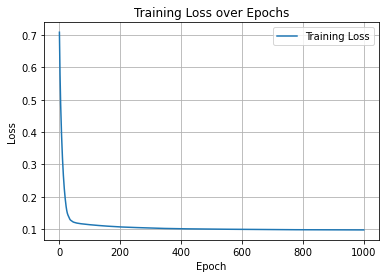

In [140]:
import matplotlib.pyplot as plt

# Lists to store loss and evaluation metrics during training
losses = []

# Set the number of training epochs
num_epochs = 1000

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the loss for plotting
    losses.append(loss.item())

    # Print the loss for every few epochs
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss during training
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [141]:
# Evaluate the model on the test set

with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted_probs = outputs.numpy()
    predicted_labels = (predicted_probs > 0.2).astype(int)
    accuracy_nn = (predicted_labels == y_test_tensor.numpy().reshape(-1, 1)).mean()
    print(f'Test Accuracy: {accuracy_nn:.4f}')

    
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted_probs = outputs.numpy()
    predicted_labels = (predicted_probs > 0.2).astype(int)
    true_labels = y_test_tensor.numpy().reshape(-1, 1)

    # Calculate precision
    precision_nn = precision_score(true_labels, predicted_labels)

    # Calculate recall
    recall_nn = recall_score(true_labels, predicted_labels)

    # Calculate F1-score
    f1_nn = f1_score(true_labels, predicted_labels)

    # Calculate AUC-ROC
    auc_roc_nn = roc_auc_score(true_labels, predicted_probs)

    # Get ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    
    # Run time
    t0=time.time()
    time_taken_nn = time.time()-t0

    
print(f"Precision_nn: {precision_nn:.4f}")
print(f"Recall_nn: {recall_nn:.4f}")
print(f"F1-score_nn: {f1_nn:.4f}")
print(f"AUC-ROC_nn: {auc_roc_nn:.4f}")
print("Time taken_nn = {}".format(time_taken_nn))
x = np.linspace(0,1,1000)
plt.plot(x,x, linestyle='dashed', c = 'blue')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


Test Accuracy: 0.9146
Precision_nn: 0.3098
Recall_nn: 0.6628
F1-score_nn: 0.4222
AUC-ROC_nn: 0.9290
Time taken_nn = 7.152557373046875e-07


# Calculating CV for each column

In [142]:
# Calculate the coefficient of variation (CV%) for each column
cv = (df2.std() / df2.mean()) * 100

# Print the CV% for each column
for column, cv_value in cv.items():
    print("CV% for column '{}': {:.2f}".format(column, cv_value))


CV% for column 'TAVG(Degrees Celsius)': 7.54
CV% for column 'TMAX(Degrees Celsius)': 7.37
CV% for column 'TMIN(Degrees Celsius)': 6.81
CV% for column 'PRCP .mm': 21.75


In [143]:

# Calculate the coefficient of variation (CV%) for the entire DataFrame df1
cv = (df2.values.std() / df2.values.mean()) * 100

# Print the CV%
print("CV% for DataFrame df1: {:.2f}".format(cv))

CV% for DataFrame df1: 58.18


# Statistical description

In [144]:

df2.describe()

TAVG(Degrees Celsius)  TMAX(Degrees Celsius)  TMIN(Degrees Celsius)  \
count           14609.000000           14609.000000            14609.00000   
mean               26.911490              31.712229               21.98365   
std                 2.030243               2.337306                1.49772   
min                21.670000              23.890000               15.56000   
25%                25.560000              30.560000               21.11000   
50%                26.670000              32.220000               22.22000   
75%                28.330000              32.220000               22.78000   
max                36.670000              41.110000               28.33000   

           PRCP .mm  
count  14609.000000  
mean       0.954822  
std        0.207701  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

# Calculating the mean and the median

In [145]:
#Rainfall data
rainfall_data = [df2]

# Calculate the median and mean
median = np.median(rainfall_data)
mean = np.mean(rainfall_data)

# Print the result
print("Mean rainfall: ", mean)
print("Median rainfall: ", median)


Mean rainfall:  20.39054777876651
Median rainfall:  23.89


In [146]:
 #Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in df2.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df2[col] = lencoders[col].fit_transform(df2[col])
    
import warnings
warnings.filterwarnings("ignore")

MiceImputed1 = df2.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed1.iloc[:, :] = mice_imputer.fit_transform(df2)

MiceImputed1.head()


TAVG(Degrees Celsius)  TMAX(Degrees Celsius)  \
Date                                                       
2000-01-09                  29.44                  32.22   
1989-05-04                  29.44                  32.22   
1987-09-02                  29.44                  32.22   
2008-10-26                  29.44                  32.22   
2016-08-15                  25.56                  26.67   

            TMIN(Degrees Celsius)  PRCP .mm  
Date                                         
2000-01-09                  22.22       0.0  
1989-05-04                  22.22       0.0  
1987-09-02                  22.22       0.0  
2008-10-26                  22.22       0.0  
2016-08-15                  22.78       0.0

In [147]:
MiceImputed1.isna()

TAVG(Degrees Celsius)  TMAX(Degrees Celsius)  \
Date                                                       
2000-01-09                  False                  False   
1989-05-04                  False                  False   
1987-09-02                  False                  False   
2008-10-26                  False                  False   
2016-08-15                  False                  False   
...                           ...                    ...   
2018-10-05                  False                  False   
1990-05-21                  False                  False   
2013-10-11                  False                  False   
2017-07-15                  False                  False   
1990-05-20                  False                  False   

            TMIN(Degrees Celsius)  PRCP .mm  
Date                                         
2000-01-09                  False     False  
1989-05-04                  False     False  
1987-09-02                  False     False  
2008-10-26                  False     False  
2016-08-15                  False     False  
...                           ...       ...  
2018-10-05                  False     False  
1990-05-21                  False     False  
2013-10-11                  False     False  
2017-07-15                  False     False  
1990-05-20                  False     False  

[14609 rows x 4 columns]

Nonetheless, we can dig deeper into pairwise correlation among these highly associated traits by looking at the following pairplot. There is a relatively minor overlap between them.

In [148]:
# Correlation Heatmap
corr = MiceImputed1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

<AxesSubplot:>

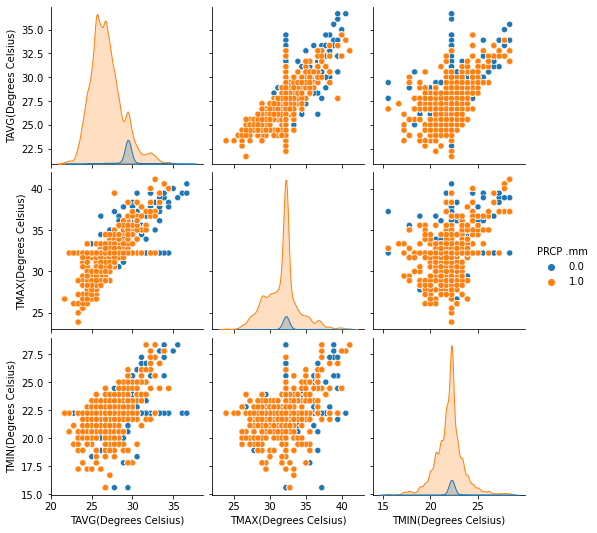

In [149]:
sns.pairplot( data=MiceImputed1, vars=('TAVG(Degrees Celsius)','TMAX(Degrees Celsius)','TMIN(Degrees Celsius)'), hue='PRCP .mm' )

# serial correlation

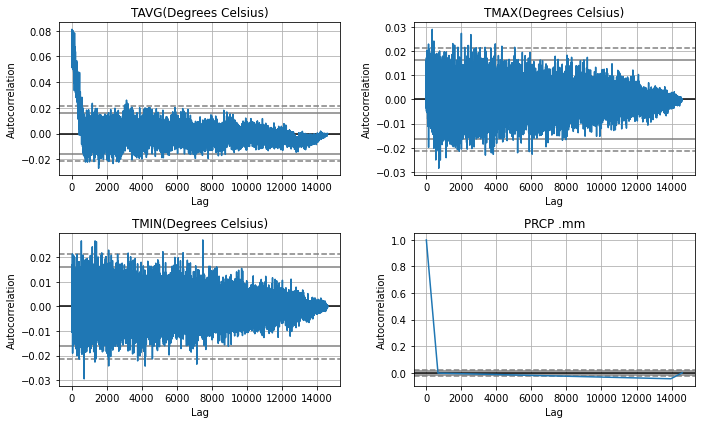

In [150]:
df2 = pd.DataFrame(df2)

# Plot autocorrelation for each variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axes = axes.flatten()

for i, col in enumerate(df2.columns):
    pd.plotting.autocorrelation_plot(df2[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [151]:
autocorr_results = df2.apply(lambda x: x.autocorr())
# Output autocorrelation results

print(autocorr_results)

TAVG(Degrees Celsius)    0.067966
TMAX(Degrees Celsius)    0.012099
TMIN(Degrees Celsius)   -0.001999
PRCP .mm                 0.999206
dtype: float64


# Logistic Regression 

Accuracy: 0.9485354503148098
Precision: 0.34
Recall: 0.09883720930232558
AUC: 0.8871590294154983
F1-score: 0.15315315315315314
Time taken for training (seconds): 0.28841519355773926
Time taken for prediction (seconds): 0.003702878952026367


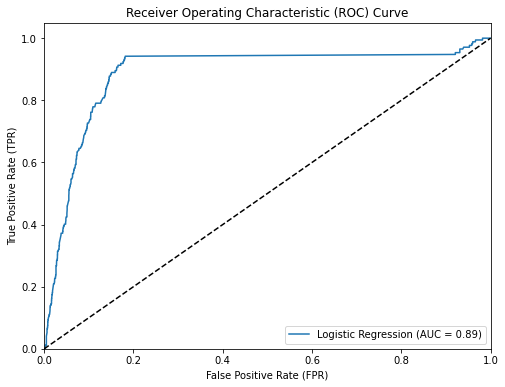

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import time

# Assuming you have your feature matrix X and target variable y

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the logistic regression model with desired parameters
params_lr = {'penalty': 'l1', 'solver': 'liblinear'}
model_lr = LogisticRegression(**params_lr)

# Train the model and measure the time taken
start_time = time.time()
model_lr.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions on the test data and measure the time taken
start_time = time.time()
y_pred = model_lr.predict(X_test)
prediction_time = time.time() - start_time

y_pred_proba = model_lr.predict_proba(X_test)[:, 1]  # Probability of positive class

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)
print("F1-score:", f1)
print("Time taken for training (seconds):", training_time)
print("Time taken for prediction (seconds):", prediction_time)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Model Comparison

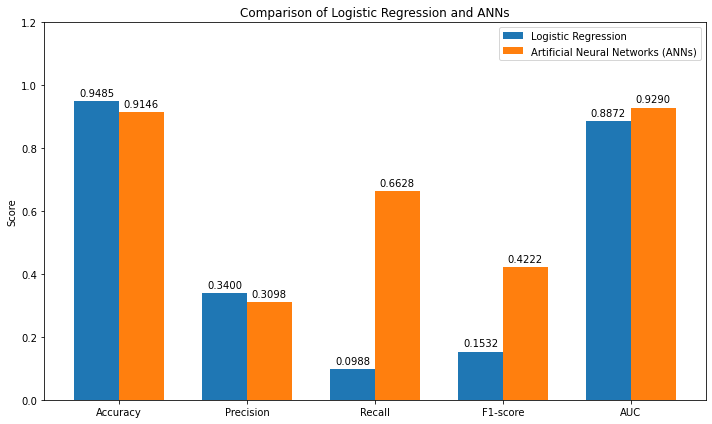

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import time

# Plotting the comparison using a bar chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
logreg_scores = [accuracy, precision, recall, f1, auc]
ann_scores = [accuracy_nn, precision_nn, recall_nn, f1_nn, auc_roc_nn]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, logreg_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, ann_scores, width, label='Artificial Neural Networks (ANNs)')

ax.set_ylabel('Score')
ax.set_title('Comparison of Logistic Regression and ANNs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.2)
plt.tight_layout()
plt.show()

# Chi-square

In [154]:
import scipy.stats as stats

# Create contingency table
contingency_table = pd.crosstab(df2['TAVG(Degrees Celsius)'], df2['PRCP .mm'])

# Calculate chi-square test statistic, p-value, degrees of freedom, and expected frequencies
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Calculate Cramer's V
def cramers_v(chi2, n, dof):
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramers_v_value = cramers_v(chi2_statistic, contingency_table.sum().sum(), dof)

# Print the results
print("Chi-square test statistic:", chi2_statistic)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies:")
print(expected)
print("Cramer's V:", cramers_v_value)


Chi-square test statistic: 4394.663648223626
P-value: 0.0
Degrees of freedom: 27
Expected frequencies:
[[9.48730235e-01 2.00512698e+01]
 [1.89746047e+00 4.01025395e+01]
 [1.49086180e+00 3.15091382e+01]
 [9.71319050e+00 2.05286810e+02]
 [2.38989664e+01 5.05101034e+02]
 [4.09309330e+01 8.65069067e+02]
 [5.15476761e+01 1.08945232e+03]
 [8.94517079e+01 1.89054829e+03]
 [7.39106031e+01 1.56208940e+03]
 [8.34430830e+01 1.76355692e+03]
 [6.60045178e+01 1.39499548e+03]
 [5.15928537e+01 1.09040715e+03]
 [3.62324594e+01 7.65767541e+02]
 [2.06913546e+01 4.37308645e+02]
 [5.55233076e+01 1.17347669e+03]
 [1.58121706e+01 3.34187829e+02]
 [9.89390102e+00 2.09106099e+02]
 [5.28578274e+00 1.11714217e+02]
 [5.87309193e+00 1.24126908e+02]
 [6.91217742e+00 1.46087823e+02]
 [4.65329591e+00 9.83467041e+01]
 [1.94263810e+00 4.10573619e+01]
 [8.58374974e-01 1.81416250e+01]
 [1.26497365e+00 2.67350264e+01]
 [4.51776302e-02 9.54822370e-01]
 [4.51776302e-02 9.54822370e-01]
 [4.51776302e-02 9.54822370e-01]
 [9.03